In [25]:
import pandas as pd
import scipy.stats as sps
import numpy as np
from collections import defaultdict
import psycopg2
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import copy
from math import log

In [26]:
projects = ['ru.stackoverflow.com','datascience.stackexchange.com','arduino.stackexchange.com',
            'cstheory.stackexchange.com','sqa.stackexchange.com','softwareengineering.stackexchange.com',
            'stats.stackexchange.com', 'ai.stackexchange.com','cseducators.stackexchange.com',
            'android.stackexchange.com','travel.stackexchange.com']

In [30]:
# отправить SQL запрос в нашу БД
def data_request(request):
    connection = psycopg2.connect(dbname='sinya', user='postgres', 
                        password='11111', host='127.0.0.1')
    cursor = connection.cursor()
    cursor.execute(request)
    records = cursor.fetchall()
    cursor.close()
    connection.close()
    return records


# разбить список тегов на отдельные, построить словарь частот
def dict_of_tags(data,split_fun = split_tags):
    d = defaultdict(int)
    for unit in data:
        if unit[0]:
            for tag in split_fun(unit[0]):
                d[tag] +=1
    return d


#выбрать из словаря самые популярные
def list_of_popular_tags(dictionary, top = 5):
    tags = list(dictionary.items())
    tags.sort(key=lambda p: -p[1])
    return tags[:top]


def plot_hist_top_n(top_n, project_id, ylabel, xlabel = 'Tags',period = 'all time'):
    names,counts = zip(*top_n)
    plt.figure(figsize=[15, 7])
    plt.title(f'Top {top} {xlabel} in Posts on {projects[project_id-1]} per {period}', fontsize=20)
    plt.ylabel(ylabel, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.xticks(rotation=65)
    plt.bar(names,counts, width=0.9)
    plt.show()
    
    # разбить список тегов на отдельные, построить словарь весов
def weight_dict_of_tags(data,pub_date, split_fun = split_tags):
    d = defaultdict(float)
    for unit in data:
        if unit[0] is not None:
            view_count = unit[1]
            life_time = (pub_date  - unit[2].date())/ timedelta(days = 1)
            weight = view_count/life_time
            for tag in split_fun(unit[0]):
                d[tag] +=weight
    return d

    
    # возвращает словарь весов тегов, посчитанных на постах созданных за указанный период

def w_tags_per_period(project_id,start_date,final_date,split_fun):
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM posts' +  
                        f' WHERE "ProjectId" = {project_id} AND "CreationDate" > \'{start_date}\' '+
                        f' AND "CreationDate" < \'{final_date}\' ;')
    return weight_dict_of_tags(data,pub_date,split_fun)
        
def w_ngrams_per_period(project_id,start_date,final_date,n):
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    data = data_request(f'SELECT "Title","ViewCount","CreationDate" FROM posts' +  
                        f' WHERE "ProjectId" = {project_id} AND "CreationDate" > \'{start_date}\' '+
                        f' AND "CreationDate" < \'{final_date}\' ;')
    d_title = weight_dict_of_tags(data,pub_date,split_fun = lambda x: split_to_ngrams(x, n, TRASH))
    return d_title

# чистим слова от слишком популярных и стоп слов
def purify(dictionary):
    trash = trash_set()
    for word in copy.deepcopy(dictionary).keys():
        if word.lower() in trash:
            del dictionary[word]
        else:
            dictionary[word.lower()] = dictionary.pop(word)
        
    return dictionary

def trash_set():
    common = []
    with open('/Users/sinya/JB_practice/vocabular.txt', 'r', encoding='utf8') as f: 
        soup = BeautifulSoup(f)
        text = soup.get_text()
        # break into lines and remove leading and trailing space on each
        for line in text.splitlines():
             common += line.strip().split()
            
                
                    
    # build collections of words we need to delete
    english_stopwords = set(stopwords.words("english"))
    russian_stopwords = set(stopwords.words("russian"))
    common_words = set(common)
    specials = set(list(',./?":*(){}[]$``\'<>'))
    
    return english_stopwords | common_words | russian_stopwords | specials

TRASH = trash_set()

def split_to_ngrams(title, n, trash):
    # тут уже точно нормально tokenize, просто с# станет биграммой и ладно
    words = [w.lower() for w in nltk.word_tokenize(title) if w.lower() not in trash] 
    ngrams = list(nltk.ngrams(words, n))
    return ngrams



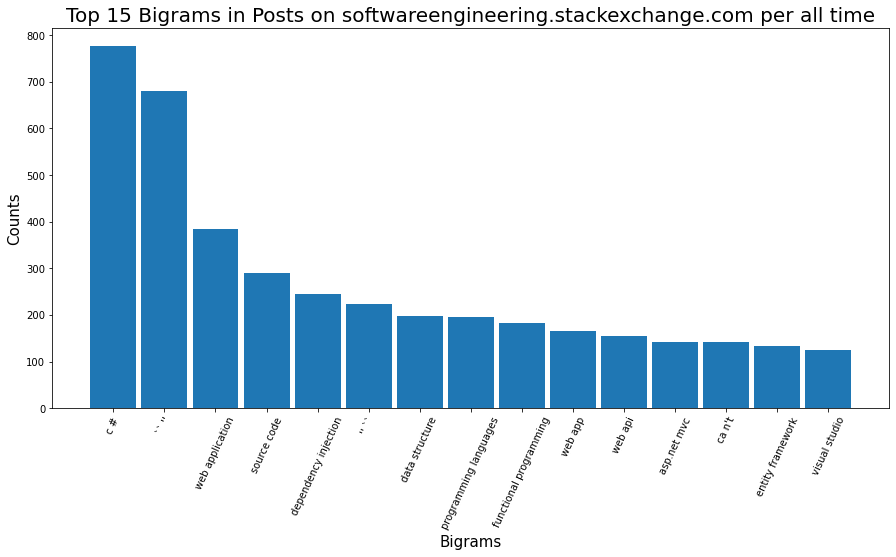

In [31]:
# поищем самые популярные биграммы и триграммы по counts

project_id = 6
top = 15

data = data_request(f'SELECT "Title" FROM public.posts WHERE "ProjectId" = {project_id} AND "Title" IS NOT NULL;')
trash = trash_set()
d = dict_of_tags(data, split_fun = lambda x: split_to_ngrams(x, 2, trash))
top_10 = list_of_popular_tags(d,top)

# танцы с бубном, чтобы избавиться от всевозможных tuple 
def reform(top_n):
    top = [list(el) for el in top_n]
    for i,pair in enumerate(top):
        top[i][0] = " ".join(pair[0])
    return top

plot_hist_top_n(reform(top_10), project_id, ylabel = "Counts", xlabel = 'Bigrams')

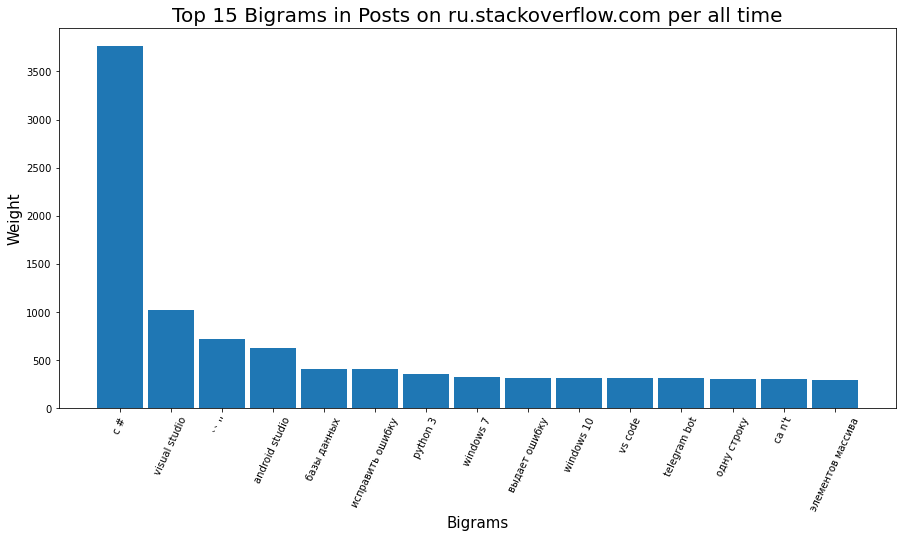

In [29]:
# поищем самые популярные биграммы и триграммы по весу 

project_id = 1
top = 15

data = data_request(f'SELECT "Title","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} AND "Title" IS NOT NULL;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
d_title = weight_dict_of_tags(data,pub_date,split_fun = lambda x: split_to_ngrams(x, 2, trash))
top_10 = list_of_popular_tags(d_title, top)

plot_hist_top_n(reform(top_10), project_id, ylabel = "Weight", xlabel = "Bigrams")

In [14]:
# Наша метрика3 = (вес за этот год - вес за прошлый год)/вес за прошлый год


def WY_tags(project_id, top, choose_from_top = 100):
    cur_year = w_tags_per_period(project_id, start_date = '2021-03-01',final_date = '2022-03-01',split_fun = split_tags)
    last_year = w_tags_per_period(project_id, start_date = '2020-03-01',final_date = '2021-03-01',split_fun = split_tags)
    
    metric ={}
    for tag in cur_year.keys():
        if (tag in last_year.keys()) and (last_year[tag] != 0) :  
            metric[tag] = (cur_year[tag]-last_year[tag])/last_year[tag]*100
    
    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    top_100 = list_of_popular_tags(weight_dict_of_tags(data,pub_date),choose_from_top)
    tags_100,_ = zip(*top_100)

    metric_sufficient = {}
    for tag in tags_100:
        if tag in metric.keys():
            metric_sufficient[tag] = metric[tag]
    
    metric_popular = list_of_popular_tags(metric_sufficient,top)
    return(metric_popular)


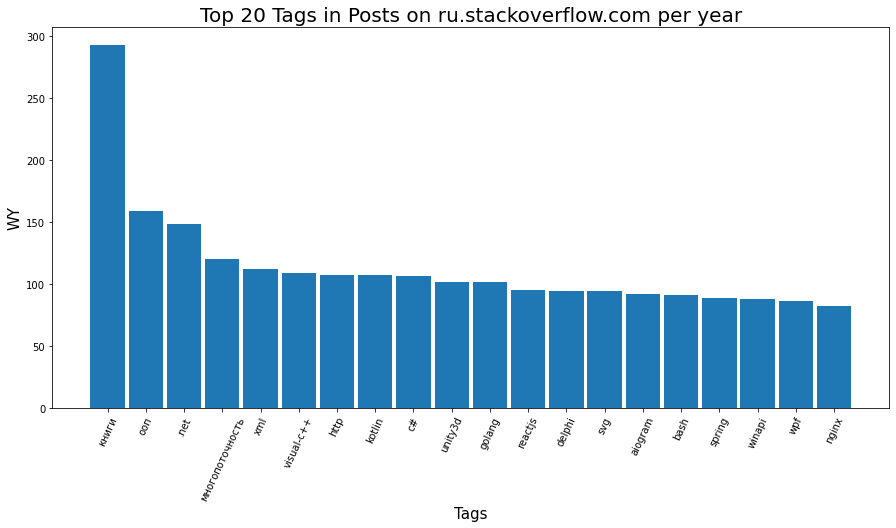

In [15]:
project_id = 1
top = 20

metric_popular = WY_tags(project_id, top)
plot_hist_top_n(metric_popular, project_id, ylabel = 'WY', period = 'year')


In [16]:
# Наша метрика4 = вес за этот месяц/средний вес за месяц, усредненный за последний год

def WM_tags(project_id, top, choose_from_top = 100):

    cur_month = w_tags_per_period(project_id, start_date = '2022-02-01',final_date = '2022-03-01', split_fun = split_tags)
    # to do: автоматическую генерацию этого списка
    months = ['2022-02-01','2022-01-01','2021-12-01','2021-11-01','2021-10-01',
         '2021-09-01','2021-08-01','2021-07-01','2021-06-01','2021-05-01','2021-04-01','2021-03-01','2021-02-01']

    average_month = defaultdict(int)

    final_date = months[0]
    for i in range(1,13):
        start_date = months[i]
        month = w_tags_per_period(project_id,start_date,final_date, split_fun = split_tags)
        for tag in month.keys():
            average_month[tag] += (month[tag]/12)
        final_date = start_date
    
    metric ={}
    for tag in cur_month.keys():
        if average_month[tag] != 0:
            metric[tag] = (cur_month[tag] - average_month[tag])/average_month[tag]

    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    top_100 = list_of_popular_tags(weight_dict_of_tags(data,pub_date),choose_from_top)
    tags_100,_ = zip(*top_100)

    metric_sufficient = {}
    for tag in tags_100:
        if tag in metric.keys():
            metric_sufficient[tag] = metric[tag]
    
    metric_popular = list_of_popular_tags(metric_sufficient,top)
    
    return(metric_popular)

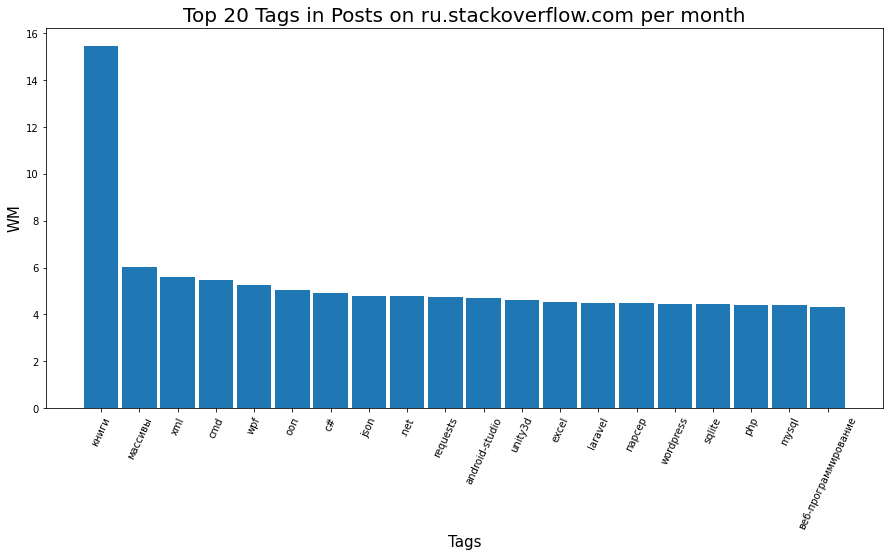

--- 15.501102924346924 seconds ---


In [18]:
import time
start_time = time.time()
project_id = 1
top = 20

metric_popular = WM_tags(project_id, top)
plot_hist_top_n(metric_popular, project_id, ylabel = 'WM', period = 'month')
print("--- %s seconds ---" % (time.time() - start_time))

In [21]:

# танцы с бубном, чтобы избавиться от всевозможных tuple 
def reform(top_n):
    top = top = [list(el) for el in top_n]
    for i,pair in enumerate(top):
        top[i][0] = " ".join(pair[0])
    return top

# top самых популярных ngram по WY
def WY_ngrams (project_id, top, n, choose_from_top = 100):
   
    cur_year = w_ngrams_per_period(project_id, start_date = '2021-03-01',final_date = '2022-03-01',n=n) 
    last_year = w_ngrams_per_period(project_id, start_date = '2020-03-01',final_date = '2021-03-01',n=n)
    
    metric ={}
    for tag in cur_year.keys():
        if (tag in last_year.keys()) and (last_year[tag] != 0) :  
            metric[tag] = (cur_year[tag]-last_year[tag])/last_year[tag]
    
    metric_popular = list_of_popular_tags(metric,top)

    plot_hist_top_n(reform(metric_popular), project_id, xlabel = f'{n}grams',ylabel = 'WY', period = 'year')
   
   

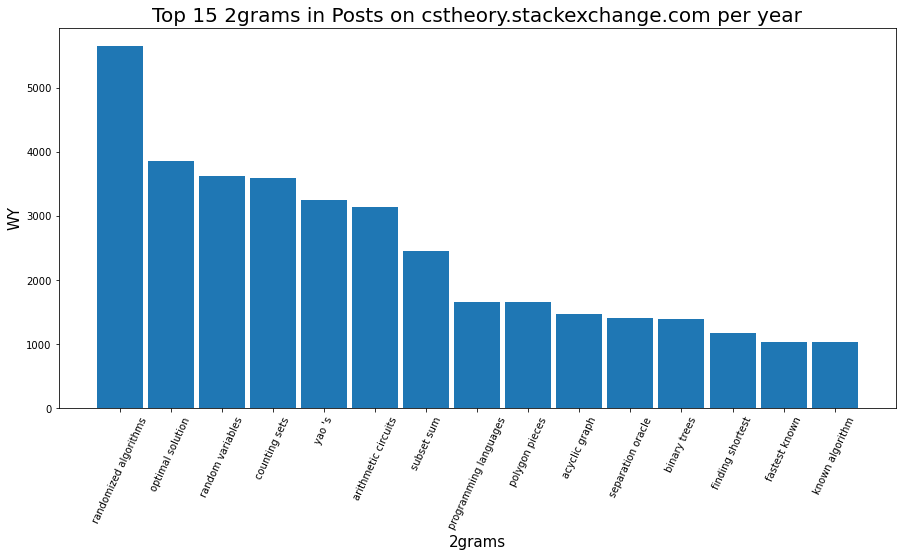

In [10]:
project_id = 4
top = 15

WY_ngrams(project_id, top, 2)

In [11]:
# top самых популярных ngram по WY из тех, в которых есть слова из топ 100 тегов

def WY_ngrams_from_top_tags (project_id, top, n, choose_from_top = 100):
   
    cur_year = w_ngrams_per_period(project_id, start_date = '2021-03-01',final_date = '2022-03-01',n=n) 
    last_year = w_ngrams_per_period(project_id, start_date = '2020-03-01',final_date = '2021-03-01',n=n)
    
    metric ={}
    for tag in cur_year.keys():
        if (tag in last_year.keys()) and (last_year[tag] != 0) :  
            metric[tag] = (cur_year[tag]-last_year[tag])/last_year[tag]
            
    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    top_100 = list_of_popular_tags(weight_dict_of_tags(data,pub_date),choose_from_top)
    tags_100,_ = zip(*top_100)
    tags_100 = set(tags_100)
    
    metric_sufficient = {}
    for tags_tuple in metric.keys():
        for tag in tags_tuple:
            if (tag in tags_100) and (tags_tuple not in metric_sufficient.keys()) :
                metric_sufficient[tags_tuple] = metric[tags_tuple]
                
    metric_popular = list_of_popular_tags(metric_sufficient,top)
    plot_hist_top_n(reform(metric_popular), project_id, xlabel = f'{n}grams', ylabel = 'WY', period = 'year')
             

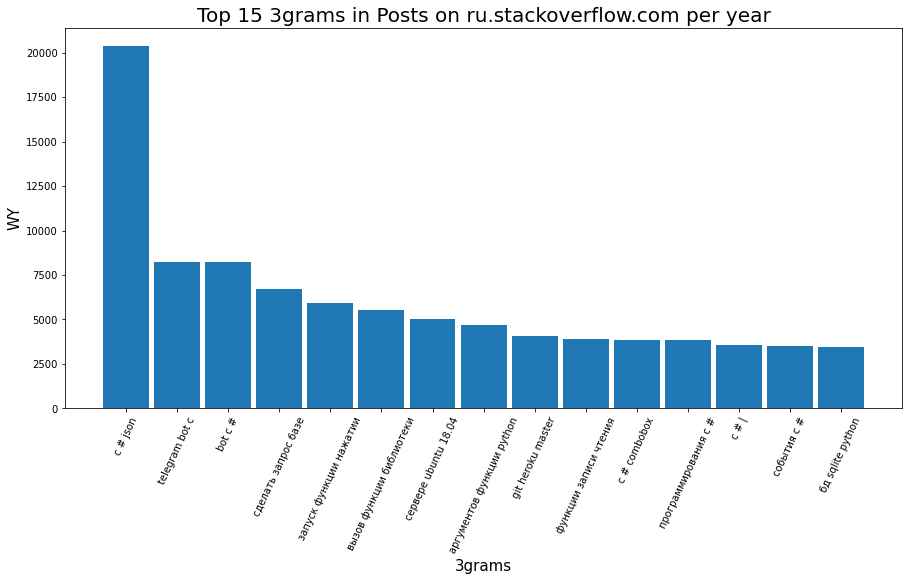

In [12]:
project_id = 1
top = 15

WY_ngrams_from_top_tags(project_id, top, 3)


In [13]:
# top самых популярных ngram по MW 

def WM_ngrams(project_id, top, n, choose_from_top = 100):

    cur_month = w_ngrams_per_period(project_id, start_date = '2022-02-01',final_date = '2022-03-01', n=n)
    # to do: автоматическую генерацию этого списка
    months = ['2022-02-01','2022-01-01','2021-12-01','2021-11-01','2021-10-01',
         '2021-09-01','2021-08-01','2021-07-01','2021-06-01','2021-05-01','2021-04-01','2021-03-01','2021-02-01']

    average_month = defaultdict(int)

    final_date = months[0]
    for i in range(1,13):
        start_date = months[i]
        month =  w_ngrams_per_period(project_id,start_date,final_date, n=n)
        for tag in month.keys():
            average_month[tag] += (month[tag]/12)
        final_date = start_date
    
    metric ={}
    for tag in cur_month.keys():
        if average_month[tag] != 0:
            metric[tag] = (cur_month[tag] - average_month[tag])/average_month[tag]
                
    metric_popular = list_of_popular_tags(metric,top)
    plot_hist_top_n(reform(metric_popular), project_id, xlabel = f'{n}grams', ylabel = 'WM', period = 'month')
    

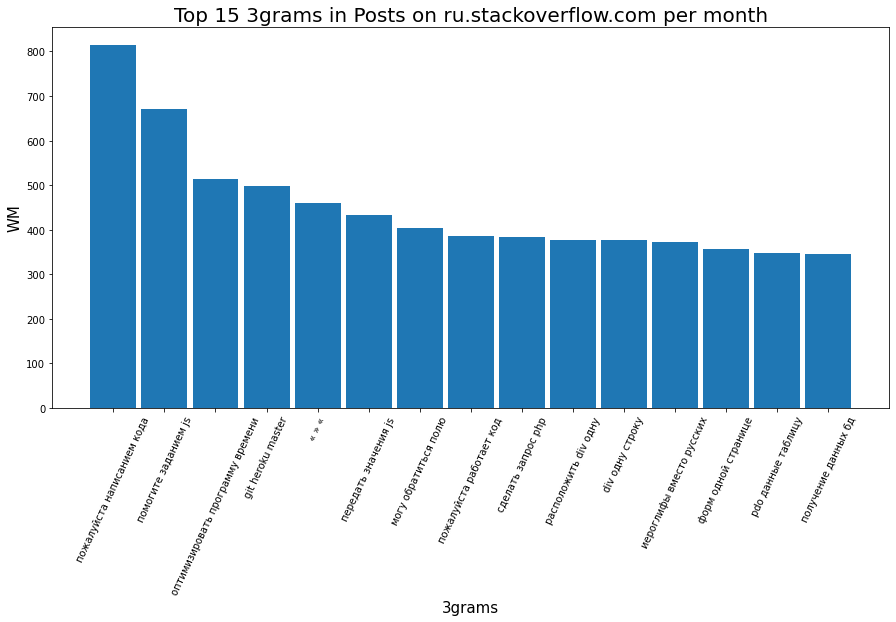

In [14]:
project_id = 1
top = 15

WM_ngrams(project_id, top, 3)

In [19]:
# top самых популярных ngram по MW из тех, в которых есть слова из топ 100 тегов

def WM_ngrams_from_top_tags(project_id, top, n, choose_from_top = 100):

    cur_month = w_ngrams_per_period(project_id, start_date = '2022-02-01',final_date = '2022-03-01', n=n)
    # to do: автоматическую генерацию этого списка
    months = ['2022-02-01','2022-01-01','2021-12-01','2021-11-01','2021-10-01',
         '2021-09-01','2021-08-01','2021-07-01','2021-06-01','2021-05-01','2021-04-01','2021-03-01','2021-02-01']

    average_month = defaultdict(int)

    final_date = months[0]
    for i in range(1,13):
        start_date = months[i]
        month =  w_ngrams_per_period(project_id,start_date,final_date, n=n)
        for tag in month.keys():
            average_month[tag] += (month[tag]/12)
        final_date = start_date
    
    metric ={}
    for tag in cur_month.keys():
        if average_month[tag] != 0:
            metric[tag] = (cur_month[tag] - average_month[tag])/average_month[tag]
            
            
    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    top_100 = list_of_popular_tags(weight_dict_of_tags(data,pub_date),choose_from_top)
    tags_100,_ = zip(*top_100)
    tags_100 = set(tags_100)
    
    metric_sufficient = {}
    for tags_tuple in metric.keys():
        for tag in tags_tuple:
            if (tag in tags_100) and (tags_tuple not in metric_sufficient.keys()) :
                metric_sufficient[tags_tuple] = metric[tags_tuple]
                
    metric_popular = list_of_popular_tags(metric_sufficient,top)
    plot_hist_top_n(reform(metric_popular), project_id, xlabel = f'{n}grams', ylabel = 'WM', period = 'month')
             

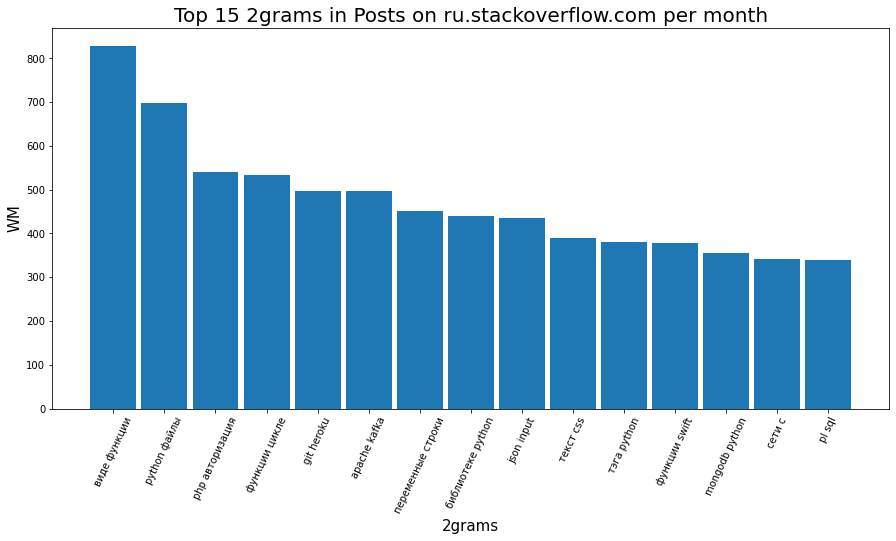

In [22]:
project_id = 1
top = 15

WM_ngrams_from_top_tags(project_id, top, 2)